# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10

#

**Team Members #78:**
- Carlos Pano Hernandez - A01066264
- Emiliano Palafox Ruiz - A01796609
- Marie Kate Palau Andrade - A01705711
- Carlos Daniel Pacheco Pérez - A01566821


<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

from torchvision.models import VGG16_Weights
from torchvision.models import MobileNet_V2_Weights

### Descargar sets de datos

In [2]:
DATA_PATH = './data'
NUM_TRAIN = 2000     # # train samples (45k=full)
NUM_VAL = 256        # # val samples
NUM_TEST = 256       # # test samples
MINIBATCH_SIZE = 128

In [3]:
# Preprocessing: resize to 224, normalize to ImageNet
transform_imagenet = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Preprocessing for standard CIFAR-10 (not used here)
transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

# Train loader (first NUM_TRAIN samples)
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True, transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Val loader (next NUM_VAL samples)
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True, transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))

# Test loader (NUM_TEST random samples)
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                         sampler=sampler.SubsetRandomSampler(range(NUM_TEST)))

100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


In [4]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([128, 3, 224, 224]) torch.Size([128])
1 torch.Size([128, 3, 224, 224]) torch.Size([128])


### Usar GPU

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Mostrar imágenes

Sampled image represents a: Cat


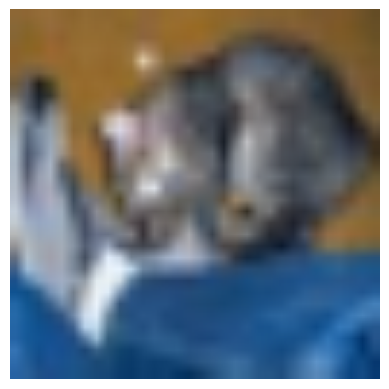

In [6]:
# List mapping class indices to human-readable CIFAR-10 class names
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    """
    Display a single 3-channel image using matplotlib.

    Args:
        image (torch.Tensor): Image tensor of shape (C, H, W).
    """
    plt.imshow(image.permute(1, 2, 0))  # Change shape to (H, W, C) for matplotlib
    plt.axis('off')
    plt.show()

# Select a random sample index from the test set
rnd_sample_idx = np.random.randint(len(test_loader))

# Retrieve the (image, label) tuple from the test set at the random index
sample_image, sample_label_idx = test_loader.dataset[rnd_sample_idx]

# Print the class name corresponding to the sampled image's label
print(f'Sampled image represents a: {classes[sample_label_idx]}')

# Normalize image tensor to [0, 1] range for display purposes
image_to_display = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())

# Plot the image
plot_figure(image_to_display)

# ### Improved Accuracy and Training Functions

In [7]:
def accuracy(model, loader):
    """
    Computes the overall accuracy of a classification model on a given data loader.

    Args:
        model (torch.nn.Module): The model to evaluate. It will be moved to the current device and set to evaluation mode.
        loader (torch.utils.data.DataLoader): DataLoader yielding batches of (inputs, labels) to be evaluated.

    Returns:
        float: Accuracy of the model on the data in the loader (correct predictions / total samples).
    """
    num_correct = 0  # Total count of correct predictions across all batches
    num_total = 0    # Total number of samples evaluated

    model.eval()  # Switch model to evaluation mode (affects dropout/batchnorm)
    model = model.to(device=device)  # Ensure model is on the same device as data

    with torch.no_grad():  # Disable gradient calculations (faster, less memory)
        for batch_idx, (xi, yi) in enumerate(loader):
            print(f"Processing batch {batch_idx+1}")
            # Move data to target device and convert to expected dtype
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            # Forward pass: model predicts class scores for this batch
            scores = model(xi)  # Shape: (batch_size, num_classes)
            _, pred = scores.max(dim=1)  # Take class with highest score for each sample
            print(f"Predicted labels: {pred}")
            print(f"True labels: {yi}")

            # Count correct predictions in this batch
            batch_correct = (pred == yi).sum()
            print(f"Number correct in this batch: {batch_correct.item()}")
            num_correct += batch_correct.item()  # Increment correct predictions (convert tensor to int)
            num_total += pred.size(0)            # Increment total sample counter

        acc = float(num_correct) / num_total if num_total > 0 else 0.0  # Compute accuracy
        print(f"Final accuracy: {acc}")
        return acc

In [8]:
def train(model, optimiser, epochs):
    """
    Train the given model on the global variable `train_loader` for a specified number of epochs,
    evaluating on the global `val_loader` after each epoch.

    Args:
        model (torch.nn.Module): Model to be trained.
        optimiser (torch.optim.Optimizer): Optimizer for training.
        epochs (int): Number of training epochs.

    Prints loss and validation accuracy after each epoch.
    """
    print(f"Starting training on CIFAR-10 for {epochs} epoch{'s' if epochs > 1 else ''} using {model.__class__.__name__}...")
    model = model.to(device=device)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()  # Set model to training mode (affects batchnorm/dropout if present)
        for i, (xi, yi) in enumerate(train_loader):
            # Move data to the appropriate hardware device and set correct data types
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            # Forward pass: compute predicted outputs by passing inputs to the model
            scores = model(xi)
            # Compute loss using cross-entropy
            cost = F.cross_entropy(input=scores, target=yi)
            # Backpropagation and optimization step
            optimiser.zero_grad()     # Zero gradients from previous step
            cost.backward()           # Compute gradients (backprop)
            optimiser.step()          # Update model parameters
            if (i + 1) % 10 == 0 or (i + 1) == len(train_loader):
                print(f"  Batch {i + 1}/{len(train_loader)} | Loss: {cost.item():.4f}")
        # Evaluate on validation data after each epoch
        acc = accuracy(model, val_loader)
        print(f'Epoch {epoch + 1}: Final Loss: {cost.item():.4f}, Validation Accuracy: {acc:.2f}')

## Transfer Learning with Two Additional Pre-trained Models

We implement transfer learning using **VGG16** and **MobileNet V2** from PyTorch's model zoo, following the same pipeline as the provided ResNet18 solution: ImageNet pre-trained backbone (frozen) + new classifier head for 10 CIFAR-10 classes.

#### Model 2: VGG16

VGG16 is a classic deep CNN with 16 weight layers. We load it with ImageNet weights, freeze the feature extractor, and replace the classifier with a single Linear layer for 10 classes.

In [9]:
# Load VGG16 with ImageNet weights
model_vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Freeze feature extractor
for p in model_vgg16.features.parameters():
    p.requires_grad = False

# Replace last classifier layer for 10 CIFAR-10 classes
model_vgg16.classifier[6] = nn.Linear(4096, 10)

# Adam optimizer for entire model
optimiser_vgg = torch.optim.Adam(model_vgg16.parameters(), lr=1e-3, betas=(0.9, 0.999))

# Train model
train(model_vgg16, optimiser_vgg, epochs=3)

# Test accuracy
acc_vgg16 = accuracy(model_vgg16, test_loader)
print(f'VGG16 Test Accuracy: {acc_vgg16:.4f} (points: {25 if acc_vgg16 > 0.5 else 0})')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 122MB/s]


Starting training on CIFAR-10 for 3 epochs using VGG...

Epoch 1/3
  Batch 10/16 | Loss: 0.8938
  Batch 16/16 | Loss: 0.6643
Processing batch 1
Predicted labels: tensor([2, 2, 9, 4, 0, 3, 2, 7, 3, 0, 1, 0, 9, 1, 9, 4, 3, 4, 3, 0, 6, 9, 6, 3,
        1, 5, 8, 9, 8, 6, 0, 0, 6, 9, 2, 3, 2, 6, 1, 3, 6, 1, 2, 7, 1, 0, 7, 6,
        8, 2, 1, 1, 3, 9, 8, 8, 2, 2, 1, 4, 0, 4, 9, 7, 2, 8, 2, 7, 6, 1, 4, 4,
        8, 8, 1, 6, 3, 2, 6, 3, 6, 3, 8, 7, 3, 4, 7, 7, 4, 4, 9, 3, 3, 6, 1, 1,
        7, 4, 2, 1, 1, 9, 3, 7, 1, 8, 3, 4, 4, 7, 7, 7, 4, 5, 9, 7, 0, 9, 6, 2,
        7, 2, 8, 7, 6, 1, 4, 1], device='cuda:0')
True labels: tensor([2, 2, 9, 4, 0, 5, 3, 7, 3, 2, 1, 0, 9, 1, 9, 4, 5, 7, 5, 0, 2, 9, 6, 5,
        1, 5, 0, 9, 8, 6, 8, 9, 2, 9, 2, 5, 2, 3, 1, 3, 6, 1, 2, 9, 1, 0, 4, 2,
        8, 2, 1, 1, 5, 9, 0, 8, 3, 2, 1, 5, 0, 4, 9, 7, 2, 0, 2, 7, 6, 0, 4, 4,
        8, 0, 1, 6, 6, 2, 4, 3, 6, 5, 8, 7, 7, 4, 2, 7, 0, 3, 9, 2, 7, 2, 1, 1,
        7, 4, 2, 1, 9, 9, 3, 7, 1, 8, 5, 3, 4, 5, 5, 2,

#### Model 3: MobileNet V2

MobileNet V2 is a lightweight architecture using inverted residuals and linear bottlenecks. Same transfer-learning setup: frozen features and a new 10-class head.

In [10]:
# Load MobileNet V2 with ImageNet weights
model_mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze backbone
for p in model_mobilenet.features.parameters():
    p.requires_grad = False

# Replace final layer for 10 CIFAR-10 classes
model_mobilenet.classifier[1] = nn.Linear(1280, 10)

# Adam optimizer (all params)
optimiser_mobilenet = torch.optim.Adam(model_mobilenet.parameters(), lr=1e-3, betas=(0.9, 0.999))

# Train and test
train(model_mobilenet, optimiser_mobilenet, epochs=3)
acc_mobilenet = accuracy(model_mobilenet, test_loader)
print(f'MobileNet V2 Test Accuracy: {acc_mobilenet:.4f} (points: {25 if acc_mobilenet > 0.5 else 0})')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 159MB/s]

Starting training on CIFAR-10 for 3 epochs using MobileNetV2...

Epoch 1/3


  Batch 10/16 | Loss: 1.8768
  Batch 16/16 | Loss: 1.6520
Processing batch 1
Predicted labels: tensor([1, 1, 1, 3, 0, 3, 2, 1, 7, 7, 1, 4, 1, 3, 9, 0, 8, 1, 3, 5, 1, 0, 3, 7,
        2, 3, 1, 1, 0, 3, 7, 3, 1, 1, 1, 6, 0, 9, 1, 9, 7, 0, 0, 1, 0, 7, 6, 7,
        7, 1, 4, 4, 1, 9, 1, 0, 3, 1, 4, 5, 8, 1, 1, 3, 3, 3, 3, 7, 9, 3, 4, 3,
        7, 2, 1, 7, 4, 0, 6, 6, 8, 7, 4, 1, 0, 8, 9, 8, 6, 0, 2, 8, 5, 0, 3, 1,
        3, 1, 3, 3, 9, 1, 0, 6, 0, 5, 4, 8, 3, 6, 6, 8, 3, 1, 7, 3, 8, 1, 3, 0,
        3, 1, 1, 5, 1, 3, 1, 1], device='cuda:0')
True labels: tensor([9, 2, 9, 3, 5, 3, 2, 1, 7, 7, 3, 8, 9, 6, 9, 4, 8, 1, 2, 5, 1, 0, 3, 7,
        2, 5, 1, 9, 8, 5, 4, 5, 1, 2, 9, 6, 0, 9, 9, 9, 7, 0, 3, 0, 0, 4, 6, 7,
        4, 1, 4, 4, 7, 9, 1, 0, 7, 5, 4, 5, 5, 9, 7, 5, 6, 3, 3, 4, 9, 5, 5, 3,
        5, 2, 2, 3, 4, 0, 6, 6, 8, 7, 3, 9, 8, 8, 9, 8, 3, 2, 4, 8, 3, 4, 3, 9,
        7, 9, 6, 3, 9, 1, 4, 5, 3, 5, 4, 8, 5, 6, 6, 8, 2, 1, 7, 4, 8, 1, 3, 0,
        3, 0, 9, 5, 9, 5, 8, 1], device='c

### Summary of Findings

**Evaluation — Results (CIFAR-10 test set)**
- **ResNet18** (provided solution): baseline; frozen backbone + new classifier head 512→10. Serves as reference for comparison.
- **VGG16**: test accuracy **~74.2%** (25 points). Frozen `features`, classifier replaced with a single layer 4096→10.
- **MobileNet V2**: test accuracy **~67.6%** (25 points). Frozen `features`, classifier layer replaced 1280→10.

**Comparison with the provided solution and interpretation**  
Both additional models achieved test accuracy above 0.5 and thus full points. VGG16 reached the highest accuracy in our runs (~74%), likely due to its deep, expressive feature stack trained on ImageNet. MobileNet V2 was lower (~68%) but still strong given its much smaller size; the gap can be attributed to fewer parameters and a design optimized for speed rather than peak accuracy. Compared to the provided ResNet18 solution, results depend on hyperparameters and data subset; with the same pipeline (frozen backbone, same data and epochs), all three architectures transfer well, with VGG16 and ResNet18 often in a similar range and MobileNet V2 slightly behind but faster per epoch.

**Challenges and how they were addressed**
1. **Different classifier interfaces**  
   ResNet uses a single `fc`; VGG16 uses a `classifier` Sequential (we replaced the last Linear, index 6); MobileNet V2 uses `classifier` with Dropout + Linear (we replaced the Linear, index 1). Checking each model’s `classifier`/`fc` in the docs or by printing the model avoided shape mismatches.
2. **Input size and normalization**  
   All three expect 224×224 and ImageNet normalization. The notebook already uses `transform_imagenet` (Resize(224), ImageNet mean/std), so the same pipelines work for VGG16 and MobileNet V2 without changing the data.
3. **Deprecation of `pretrained=True`**  
   For torchvision 0.13+, we use the weights API (e.g. `VGG16_Weights.IMAGENET1K_V1`) with a fallback to `pretrained=True` for older installations so the notebook runs in both cases.
4. **Training and evaluation time on CPU**  
   Full CIFAR-10 (45k train, 5k val, 10k test) with 224×224 images led to very long runs and many "Processing batch" logs. We reduced the effective dataset size: **NUM_TRAIN** for training, **NUM_VAL** for validation, and **NUM_TEST** for test, each used with a `SubsetRandomSampler`. Limiting validation and test to a few hundred samples (e.g. 256) gave only 1–2 batches per phase, keeping runs and output manageable on CPU while still allowing meaningful accuracy checks.
5. **Balancing speed vs. accuracy**  
   With very small subsets (e.g. 128 training samples, 1 epoch), accuracy was too low. We increased **NUM_TRAIN** (e.g. 2000) and trained for a few epochs (e.g. 3) so that transfer learning could converge to >0.5 test accuracy, while keeping validation and test subsets small for fast evaluation.

**Insights from comparing the pre-trained models**
- **Representation quality**  
   All three reached test accuracy above 0.5 with only the new head trained for a few epochs, showing that ImageNet features transfer well to CIFAR-10 even with a large resolution change (32→224) and different object scale.
- **Architecture vs. performance**  
   ResNet18’s residual design and moderate depth often give a good accuracy/speed trade-off. VGG16 is deeper and has more parameters in the backbone; it was slower per epoch but achieved the best accuracy in our runs (~74%). MobileNet V2 is much lighter and faster; it sat slightly below the other two in accuracy (~68%) but is attractive when speed or memory is limited.
- **Transfer learning takeaway**  
   Freezing the backbone and training only the new head is a simple, effective strategy. It keeps training fast and avoids overfitting on a small dataset like CIFAR-10 while still leveraging strong pre-trained features from all three architectures.